## Importing libraries

In [80]:
''' Here we shall import all the necessary libraries and functions that we will be using during the tasks. '''

' Here we shall import all the necessary libraries and functions that we will be using during the tasks. '

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.manifold import TSNE

## Device

In [81]:
''' We decide which device - CPU or GPU - to use for the training purposes. '''

' We decide which device - CPU or GPU - to use for the training purposes. '

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


## Hyperparameters

In [82]:
''' We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc. '''

' We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc. '

In [3]:
seed = 42   # for reproducibility
torch.manual_seed(seed)     # set seed for torch
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True 
batch_size = 512
epochs = 64 
learning_rate = 0.001

## Load data

In [ ]:
''' In this lab, we shall use CIFAR10 dataset which is an image classification dataset with 10 classes. '''

In [44]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=seed)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Checking the shape of the input 

print("Train data")
print(len(train_data))   # length of the train data
for batch in train_loader:
    images, labels = batch
    print(images.shape)     # shape of the images
    print(labels.shape)     # shape of the labels
    break

print("\nValidation data")
print(len(val_data))
for batch in val_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

print("\nTest data")
print(len(test_data))
for batch in test_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

Train data
40000
torch.Size([512, 3, 32, 32])
torch.Size([512])

Validation data
10000
torch.Size([512, 3, 32, 32])
torch.Size([512])

Test data
10000
torch.Size([512, 3, 32, 32])
torch.Size([512])


## Model Architecture

In [83]:
''' Here we shall define a Net architecture with 2 CNN blocks. Each block has a Adaptive Average Pooling layer and activation 
function Leaky ReLU. 
Since it is a classification problem, we shall use a softmax classifier at the output layer to get probabilistic output measures.'''

' Here we shall define a Net architecture with 2 CNN blocks. Each block has a Adaptive Average Pooling layer and activation \nfunction Leaky ReLU. \nSince it is a classification problem, we shall use a softmax classifier at the output layer to get probabilistic output measures.'

In [6]:
class GreedyNet(nn.Module):

    def __init__(self, num_channels, num_classes):

        super(GreedyNet, self).__init__()
        self.input_size = 32*32*3
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.avg_pool1 = nn.AdaptiveAvgPool2d(1)
        self.lr1 = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.avg_pool2 = nn.AdaptiveAvgPool2d(1)
        self.lr2 = nn.LeakyReLU(0.2)

        self.fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.avg_pool1(x)
        x = self.lr1(x)

        x = self.conv2(x)
        x = self.avg_pool2(x)
        x = self.lr2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

## Greedy training of 2nd Conv Block by Deactivating the 1st Conv Block

In [84]:
''' In this section, we deactivate the 1st Convolutional block by freezing its gradients - thus the layer parameters will not get 
updated in the backprop.'''

' In this section, we deactivate the 1st Convolutional block by freezing its gradients - thus the layer parameters will not get \nupdated in the backprop.'

### Defining model

In [7]:
model = GreedyNet(num_channels=3, num_classes=10)
model.to(device)

# Deactivating the first conv block

model.conv1.requires_grad = False
model.avg_pool1.requires_grad = False
model.lr1.requires_grad = False

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses1 = []
val_losses1 = []
train_acc1 = []
val_acc1 = []

for epoch in range(epochs):

    # TRAINING

    model.train()
    running_loss = 0.0
    running_corr = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corr.float()/len(train_data)
    train_losses1.append(epoch_loss)
    train_acc1.append(epoch_acc.item())


    # VALIDATION

    model.eval()
    running_loss = 0.0
    running_corr = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(val_loader)
    epoch_acc = running_corr.float()/len(val_data)
    val_losses1.append(epoch_loss)
    val_acc1.append(epoch_acc.item())

    print('Epoch [',epoch+1,'/',epochs,']') 
    print('Train Loss:',train_losses1[-1], 'Train Accuracy:', train_acc1[-1])
    print('Val Loss:',val_losses1[-1], 'Val Accuracy:',val_acc1[-1])

Epoch [ 1 / 64 ]
Train Loss: 2.294748795183399 Train Accuracy: 0.11457499861717224
Val Loss: 2.2768512606620788 Val Accuracy: 0.13759998977184296
Epoch [ 2 / 64 ]
Train Loss: 2.255650339247305 Train Accuracy: 0.16722498834133148
Val Loss: 2.2430350542068482 Val Accuracy: 0.18969999253749847
Epoch [ 3 / 64 ]
Train Loss: 2.236787177339385 Train Accuracy: 0.19637499749660492
Val Loss: 2.2342041969299316 Val Accuracy: 0.2078000009059906
Epoch [ 4 / 64 ]
Train Loss: 2.231686577012267 Train Accuracy: 0.20527499914169312
Val Loss: 2.230412185192108 Val Accuracy: 0.20749999582767487
Epoch [ 5 / 64 ]
Train Loss: 2.2285140043572533 Train Accuracy: 0.20719999074935913
Val Loss: 2.228199815750122 Val Accuracy: 0.20520000159740448
Epoch [ 6 / 64 ]
Train Loss: 2.227028333688084 Train Accuracy: 0.2072249948978424
Val Loss: 2.2276355743408205 Val Accuracy: 0.20260000228881836
Epoch [ 7 / 64 ]
Train Loss: 2.225436633146262 Train Accuracy: 0.20822499692440033
Val Loss: 2.2278039336204527 Val Accuracy: 0

### Loss curve

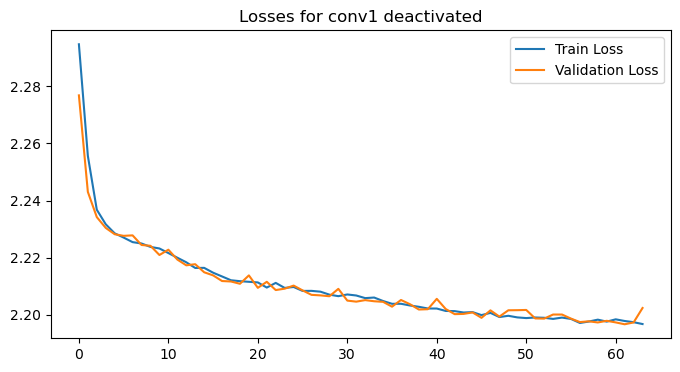

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses1, label='Train Loss')
plt.plot(val_losses1, label='Validation Loss')
plt.legend()
plt.title('Losses for conv1 deactivated')
plt.show()

### Accuracy curve

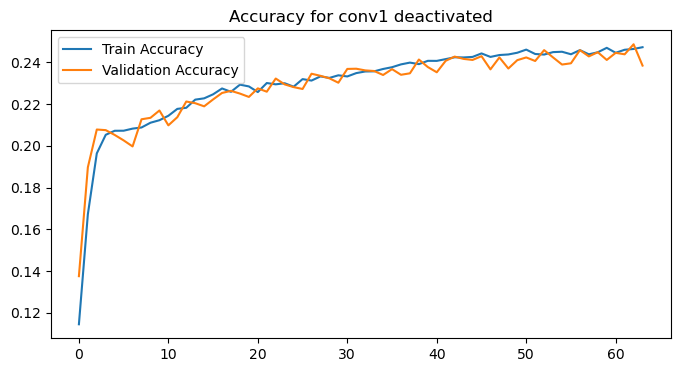

In [10]:
plt.figure(figsize=(8,4))
plt.plot(train_acc1, label='Train Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.title('Accuracy for conv1 deactivated')
plt.legend()
plt.show()

### Testing

In [67]:
model.eval()
features = []
labels = []

actual_values = []
predicted_values = []

with torch.no_grad():
    for inputs, target in test_loader:

        inputs = inputs.to(device)
        target = target.to(device)
        one_hot_labels = torch.nn.functional.one_hot(target, num_classes=10).float()

        outputs = model(inputs)
        
        features.append(outputs.cpu().numpy())
        labels.append(target.cpu().numpy())

        actual_class = np.argmax(one_hot_labels.cpu().numpy(), axis=1)
        predicted_class = np.argmax(outputs.cpu().numpy(), axis=1)

        actual_values.extend(list(actual_class))
        predicted_values.extend(list(predicted_class))

clf_report = classification_report(actual_values, predicted_values)
print(clf_report)

              precision    recall  f1-score   support

           0       0.37      0.51      0.43      1000
           1       0.27      0.12      0.17      1000
           2       0.20      0.01      0.02      1000
           3       0.22      0.07      0.10      1000
           4       0.24      0.34      0.28      1000
           5       0.19      0.31      0.23      1000
           6       0.34      0.28      0.31      1000
           7       0.19      0.18      0.19      1000
           8       0.32      0.34      0.33      1000
           9       0.21      0.40      0.28      1000

    accuracy                           0.26     10000
   macro avg       0.25      0.26      0.23     10000
weighted avg       0.25      0.26      0.23     10000



### t-SNE plot

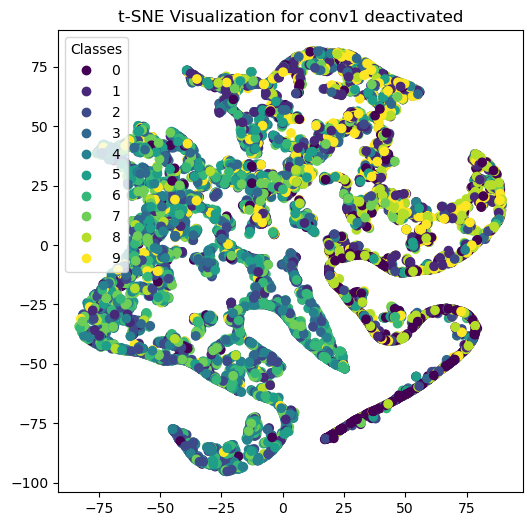

In [68]:
num_samples = 10000
features = np.vstack(features)[:num_samples]
labels = np.hstack(labels)[:num_samples]

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('t-SNE Visualization for conv1 deactivated')
plt.show()

## Greedy training of 1st Conv Block by Deactivating the 2nd Conv Block

In [85]:
''' In this section, we deactivate the 2nd Convolutional block by freezing its gradients - thus the layer parameters will not get 
updated in the backprop.'''

' In this section, we deactivate the 2nd Convolutional block by freezing its gradients - thus the layer parameters will not get \nupdated in the backprop.'

### Defining model

In [69]:
model2 = GreedyNet(num_channels=3, num_classes=10)
model2.to(device)

# Deactivating the second conv block

model2.conv2.requires_grad = False
model2.avg_pool2.requires_grad = False
model2.lr2.requires_grad = False

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

train_losses2 = []
val_losses2 = []
train_acc2 = []
val_acc2 = []

for epoch in range(epochs):

    # TRAINING

    model.train()
    running_loss = 0.0
    running_corr = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)

        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        loss = criterion(outputs, one_hot_labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corr.float()/len(train_data)
    train_losses2.append(epoch_loss)
    train_acc2.append(epoch_acc.item())


    # VALIDATION

    model.eval()
    running_loss = 0.0
    running_corr = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        outputs = model2(inputs)
        loss = criterion(outputs, one_hot_labels)
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(val_loader)
    epoch_acc = running_corr.float()/len(val_data)
    val_losses2.append(epoch_loss)
    val_acc2.append(epoch_acc.item())

    print('Epoch [',epoch+1,'/',epochs,']') 
    print('Train Loss:',train_losses2[-1], 'Train Accuracy:', train_acc2[-1])
    print('Val Loss:',val_losses2[-1], 'Val Accuracy:',val_acc2[-1])

Epoch [ 1 / 64 ]
Train Loss: 2.2970252067227905 Train Accuracy: 0.1012749969959259
Val Loss: 2.2835071682929993 Val Accuracy: 0.1096000000834465
Epoch [ 2 / 64 ]
Train Loss: 2.2587301550032217 Train Accuracy: 0.15962499380111694
Val Loss: 2.2445993423461914 Val Accuracy: 0.17579999566078186
Epoch [ 3 / 64 ]
Train Loss: 2.2374854631061796 Train Accuracy: 0.1950249969959259
Val Loss: 2.2333469867706297 Val Accuracy: 0.2061999887228012
Epoch [ 4 / 64 ]
Train Loss: 2.23120380353324 Train Accuracy: 0.20239999890327454
Val Loss: 2.229554796218872 Val Accuracy: 0.20839999616146088
Epoch [ 5 / 64 ]
Train Loss: 2.228737589679187 Train Accuracy: 0.20784999430179596
Val Loss: 2.228433358669281 Val Accuracy: 0.2094999998807907
Epoch [ 6 / 64 ]
Train Loss: 2.2268795997281616 Train Accuracy: 0.20852500200271606
Val Loss: 2.2258457779884337 Val Accuracy: 0.210999995470047
Epoch [ 7 / 64 ]
Train Loss: 2.2254573242573796 Train Accuracy: 0.2083749920129776
Val Loss: 2.22541538476944 Val Accuracy: 0.2151

### Loss curve

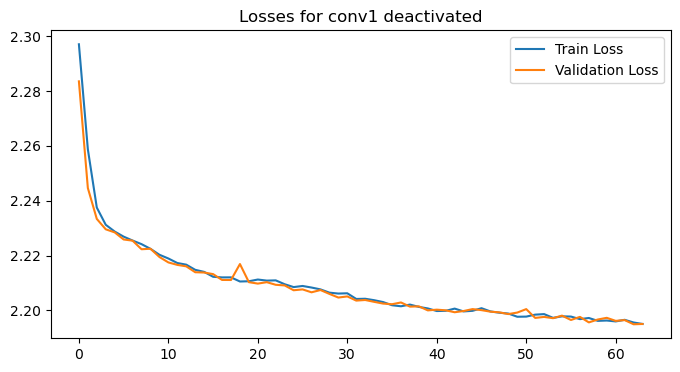

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.legend()
plt.title('Losses for conv1 deactivated')
plt.show()

### Accuracy curve

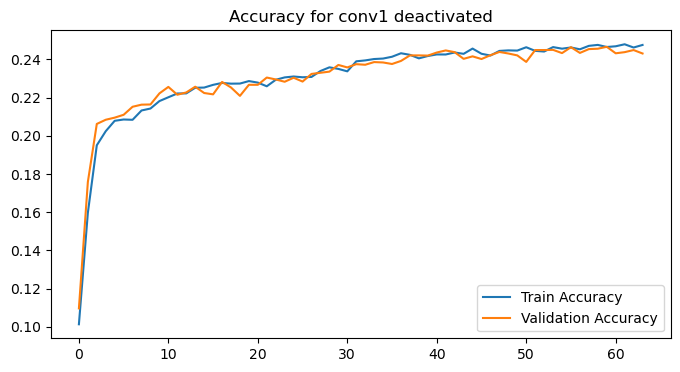

In [72]:
plt.figure(figsize=(8,4))
plt.plot(train_acc2, label='Train Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.title('Accuracy for conv1 deactivated')
plt.legend()
plt.show()

### Testing

In [73]:
model.eval()
features = []
labels = []

actual_values = []
predicted_values = []

with torch.no_grad():
    for inputs, target in test_loader:

        inputs = inputs.to(device)
        target = target.to(device)
        one_hot_labels = torch.nn.functional.one_hot(target, num_classes=10).float()

        outputs = model2(inputs)
        
        features.append(outputs.cpu().numpy())
        labels.append(target.cpu().numpy())

        actual_class = np.argmax(one_hot_labels.cpu().numpy(), axis=1)
        predicted_class = np.argmax(outputs.cpu().numpy(), axis=1)

        actual_values.extend(list(actual_class))
        predicted_values.extend(list(predicted_class))

clf_report = classification_report(actual_values, predicted_values)
print(clf_report)

              precision    recall  f1-score   support

           0       0.40      0.40      0.40      1000
           1       0.24      0.20      0.22      1000
           2       0.23      0.02      0.03      1000
           3       0.15      0.01      0.01      1000
           4       0.23      0.32      0.27      1000
           5       0.18      0.18      0.18      1000
           6       0.29      0.35      0.32      1000
           7       0.19      0.31      0.23      1000
           8       0.31      0.43      0.36      1000
           9       0.21      0.31      0.25      1000

    accuracy                           0.25     10000
   macro avg       0.24      0.25      0.23     10000
weighted avg       0.24      0.25      0.23     10000



### t-SNE plot

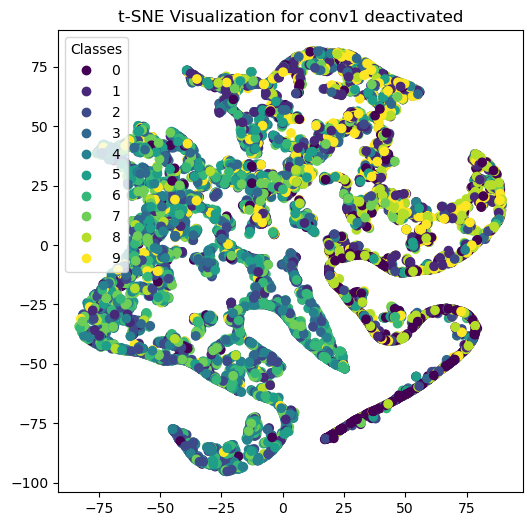

In [74]:
model.eval()
features = []
labels = []

with torch.no_grad():
    for inputs, target in test_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model(inputs)
        features.append(outputs.cpu().numpy())
        labels.append(target.cpu().numpy())

num_samples = 10000
features = np.vstack(features)[:num_samples]
labels = np.hstack(labels)[:num_samples]

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('t-SNE Visualization for conv1 deactivated')
plt.show()

## Combining both the Conv Layers

### Defining model

In [75]:
complete_model = GreedyNet(num_channels=3, num_classes=10)
complete_model.to(device)

GreedyNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool1): AdaptiveAvgPool2d(output_size=1)
  (lr1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg_pool2): AdaptiveAvgPool2d(output_size=1)
  (lr2): LeakyReLU(negative_slope=0.2)
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(complete_model.parameters(), lr=learning_rate)

train_losses3 = []
val_losses3 = []
train_acc3 = []
val_acc3 = []

for epoch in range(256):

    # TRAINING

    complete_model.train()
    running_loss = 0.0
    running_corr = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        outputs = complete_model(inputs)
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = running_corr.float()/len(train_data)
    train_losses3.append(epoch_loss)
    train_acc3.append(epoch_acc.item())


    # VALIDATION

    complete_model.eval()
    running_loss = 0.0
    running_corr = 0

    for inputs, labels in val_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        outputs = complete_model(inputs)
        loss = criterion(outputs, one_hot_labels)
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corr += torch.sum(preds == labels.data)

    epoch_loss = running_loss/len(val_loader)
    epoch_acc = running_corr.float()/len(val_data)
    val_losses3.append(epoch_loss)
    val_acc3.append(epoch_acc.item())

    print('Epoch [',epoch+1,'/',epochs,']') 
    print('Train Loss:',train_losses3[-1], 'Train Accuracy:', train_acc3[-1])
    print('Val Loss:',val_losses3[-1], 'Val Accuracy:',val_acc3[-1])

Epoch [ 1 / 64 ]
Train Loss: 2.295120544071439 Train Accuracy: 0.10662499815225601
Val Loss: 2.2800623297691347 Val Accuracy: 0.1371999979019165
Epoch [ 2 / 64 ]
Train Loss: 2.2573855194864394 Train Accuracy: 0.1694749891757965
Val Loss: 2.243434798717499 Val Accuracy: 0.18029999732971191
Epoch [ 3 / 64 ]
Train Loss: 2.2370103401473806 Train Accuracy: 0.19749999046325684
Val Loss: 2.2331565022468567 Val Accuracy: 0.2004999965429306
Epoch [ 4 / 64 ]
Train Loss: 2.230670283112345 Train Accuracy: 0.2027750015258789
Val Loss: 2.229878878593445 Val Accuracy: 0.20679999887943268
Epoch [ 5 / 64 ]
Train Loss: 2.2288180302970018 Train Accuracy: 0.20544999837875366
Val Loss: 2.228252589702606 Val Accuracy: 0.20520000159740448
Epoch [ 6 / 64 ]
Train Loss: 2.227491903908645 Train Accuracy: 0.20782499015331268
Val Loss: 2.226640260219574 Val Accuracy: 0.20629999041557312
Epoch [ 7 / 64 ]
Train Loss: 2.2263372155684458 Train Accuracy: 0.20832499861717224
Val Loss: 2.2246318817138673 Val Accuracy: 0.

### Loss curve

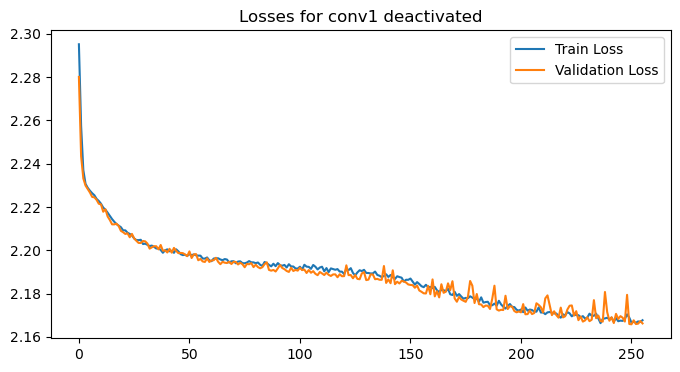

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses3, label='Train Loss')
plt.plot(val_losses3, label='Validation Loss')
plt.legend()
plt.title('Losses for conv1 deactivated')
plt.show()

### Accuracy curve

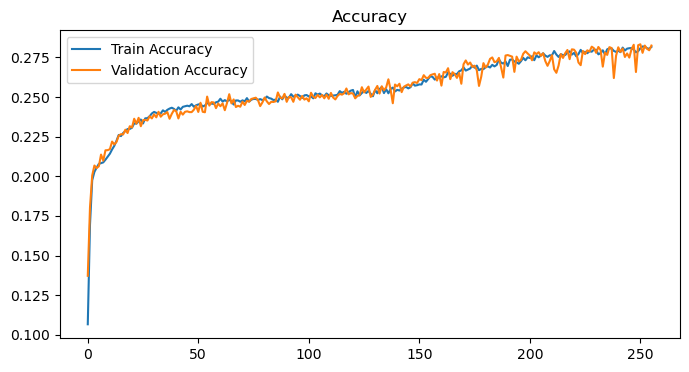

In [78]:
plt.figure(figsize=(8,4))
plt.plot(train_acc3, label='Train Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### t-SNE

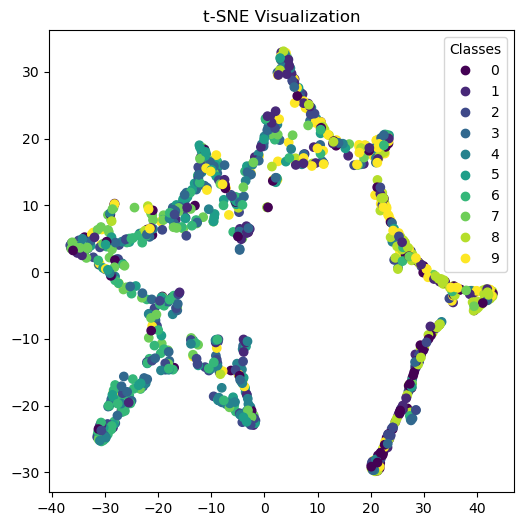

In [79]:
model.eval()
features = []
labels = []

with torch.no_grad():
    for inputs, target in test_loader:
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = complete_model(inputs)
        features.append(outputs.cpu().numpy())
        labels.append(target.cpu().numpy())

num_samples = 1000
features = np.vstack(features)[:num_samples]
labels = np.hstack(labels)[:num_samples]

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('t-SNE Visualization')
plt.show()